# Day 1: ARIMA Models for Trading

## 🎯 Learning Objectives
- Understand ARIMA components
- Build price prediction models
- Apply to trading strategies

---

## 📚 Theory: ARIMA

### Components
- **AR(p)**: AutoRegressive - past values predict future
- **I(d)**: Integrated - differencing for stationarity  
- **MA(q)**: Moving Average - past errors predict future

### Model
$$y_t = c + \sum_{i=1}^{p}\phi_i y_{t-i} + \sum_{j=1}^{q}\theta_j \epsilon_{t-j} + \epsilon_t$$

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1255 days


In [2]:
# Test for stationarity
def test_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Stationary: {'Yes' if result[1] < 0.05 else 'No'}")
    return result[1] < 0.05

print("\n" + "="*60)
print("STATIONARITY TESTS")
print("="*60)

test_stationarity(prices, 'Prices')
test_stationarity(returns, 'Returns')


STATIONARITY TESTS

Prices:
  ADF Statistic: 0.2929
  p-value: 0.9770
  Stationary: No

Returns:
  ADF Statistic: -22.0952
  p-value: 0.0000
  Stationary: Yes


True

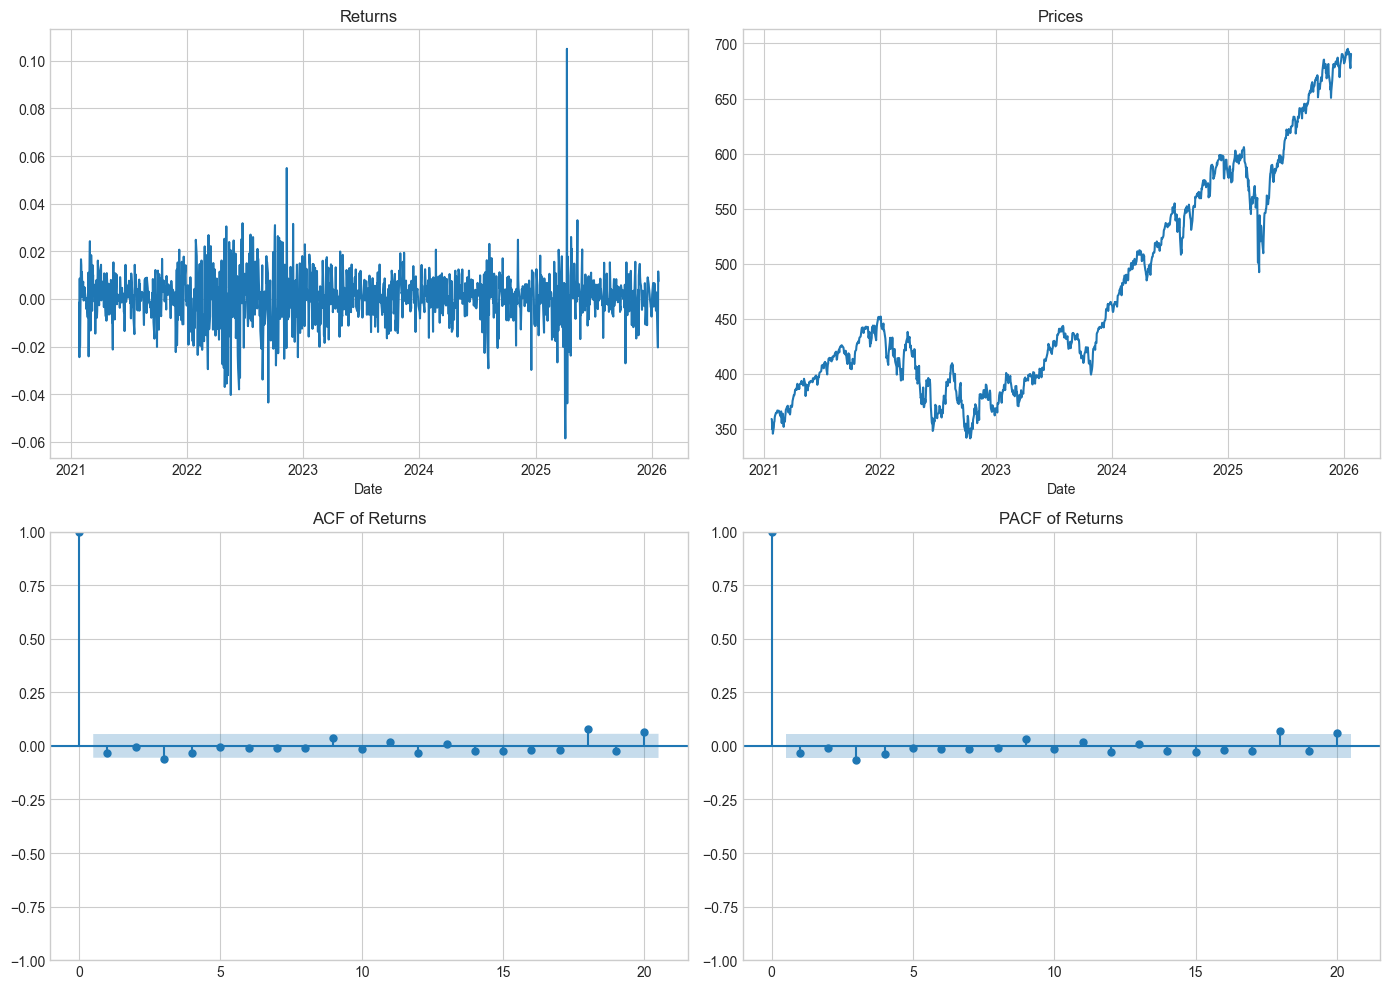

In [3]:
# ACF and PACF plots for returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(returns)
axes[0, 0].set_title('Returns')
axes[0, 0].set_xlabel('Date')

axes[0, 1].plot(prices)
axes[0, 1].set_title('Prices')
axes[0, 1].set_xlabel('Date')

plot_acf(returns.dropna(), ax=axes[1, 0], lags=20)
axes[1, 0].set_title('ACF of Returns')

plot_pacf(returns.dropna(), ax=axes[1, 1], lags=20)
axes[1, 1].set_title('PACF of Returns')

plt.tight_layout()
plt.show()

In [4]:
# Grid search for best ARIMA parameters
from itertools import product

train_size = int(len(returns) * 0.8)
train = returns.iloc[:train_size]
test = returns.iloc[train_size:]

# Quick search
best_aic = np.inf
best_order = None

p_range = range(0, 4)
d_range = [0]  # Returns are already stationary
q_range = range(0, 4)

print("\n🔍 Searching for best ARIMA parameters...")
for p, d, q in product(p_range, d_range, q_range):
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = (p, d, q)
    except:
        continue

print(f"\n✅ Best ARIMA order: {best_order}")
print(f"   Best AIC: {best_aic:.2f}")


🔍 Searching for best ARIMA parameters...

✅ Best ARIMA order: (0, 0, 0)
   Best AIC: -6309.33


In [5]:
# Fit best model
model = ARIMA(train, order=best_order)
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1003
Model:                          ARIMA   Log Likelihood                3156.663
Date:                Fri, 23 Jan 2026   AIC                          -6309.325
Time:                        00:15:59   BIC                          -6299.504
Sample:                             0   HQIC                         -6305.593
                               - 1003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.701      0.089   -8.55e-05       0.001
sigma2         0.0001   3.47e-06     31.104      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.08   Jarque-

In [6]:
# Rolling forecast on test set
predictions = []
actuals = test.values
history = list(train.values)

print("\n🔄 Making predictions...")
for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    fitted = model.fit()
    pred = fitted.forecast(steps=1)[0]
    predictions.append(pred)
    history.append(actuals[t])
    
    if (t + 1) % 50 == 0:
        print(f"  {t + 1}/{len(test)} predictions")

predictions = np.array(predictions)
print("\n✅ Predictions complete")


🔄 Making predictions...
  50/251 predictions
  100/251 predictions
  150/251 predictions
  200/251 predictions
  250/251 predictions

✅ Predictions complete


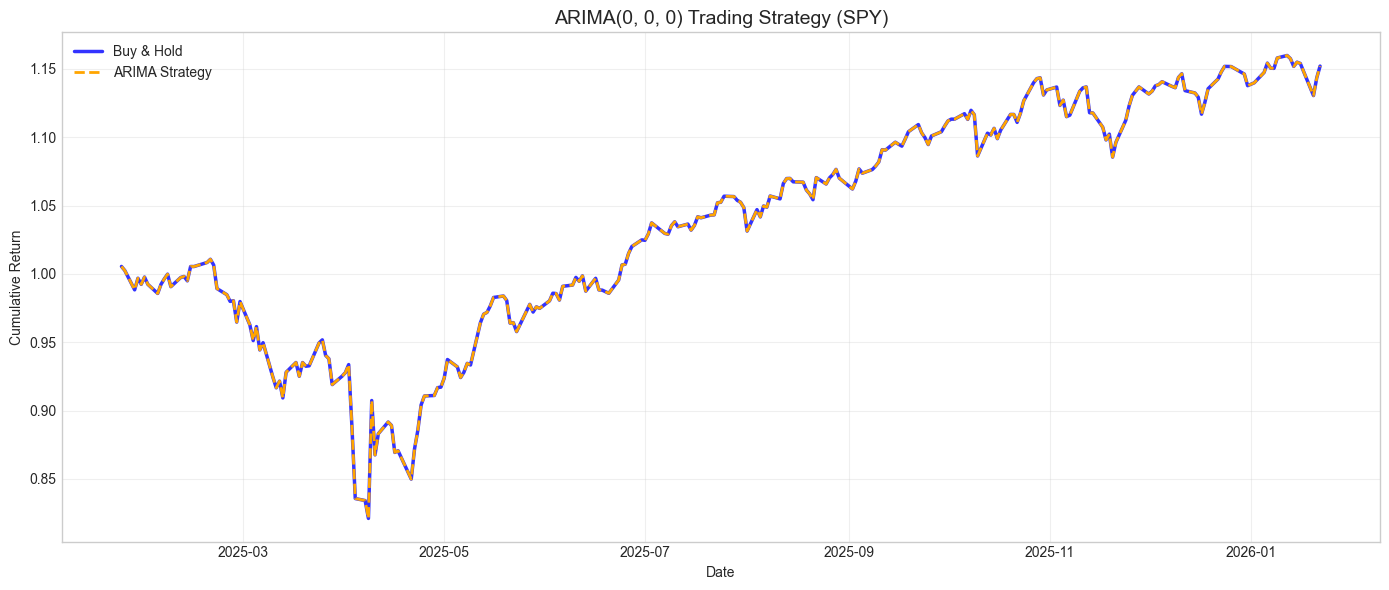

In [7]:
# Build trading strategy
df = pd.DataFrame(index=test.index)
df['actual'] = actuals
df['predicted'] = predictions
df['signal'] = np.sign(df['predicted'])  # Long if positive prediction, short if negative
df['strategy_return'] = df['signal'] * df['actual']

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['actual']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2.5, color='blue', alpha=0.8)
plt.plot(df.index, df['strategy_cum'], label='ARIMA Strategy', linewidth=2, color='orange', linestyle='--')
plt.title(f'ARIMA{best_order} Trading Strategy ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['actual'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'ARIMA Strategy':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")

# Direction accuracy
correct = (np.sign(df['predicted']) == np.sign(df['actual'])).mean()
print(f"\nDirection Accuracy: {correct:.1%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                 15.20%       0.57    -18.76%
ARIMA Strategy             15.20%       0.57    -18.76%

Direction Accuracy: 56.6%


In [9]:
# Next day prediction
final_model = ARIMA(returns, order=best_order)
final_fitted = final_model.fit()
next_pred = final_fitted.forecast(steps=1).iloc[0]

print("\n" + "="*60)
print(f"📊 ARIMA PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Current Price: ${prices.iloc[-1]:.2f}")
print(f"\nARIMA{best_order} Prediction:")
print(f"  Next Day Return: {next_pred:.4%}")
print(f"  Predicted Price: ${prices.iloc[-1] * (1 + next_pred):.2f}")
print(f"\n🎯 Signal: {'📈 LONG' if next_pred > 0 else '📉 SHORT'}")


📊 ARIMA PREDICTION FOR SPY

Date: 2026-01-22
Current Price: $690.51

ARIMA(0, 0, 0) Prediction:
  Next Day Return: 0.0575%
  Predicted Price: $690.91

🎯 Signal: 📈 LONG


---

## 🏢 Real-World Applications

| Company | ARIMA Use Case |
|---------|---------------|
| Banks | Interest rate forecasting |
| Commodities | Price prediction |
| Research | Baseline model |

---
## 📅 Tomorrow: GARCH Volatility Models